Starting EDA...
EDA finished


/home/filippocasari/.conda/envs/Sample1ProjectML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:827: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.
  warnings.warn("algorithm='elkan' doesn't make sense for a single "


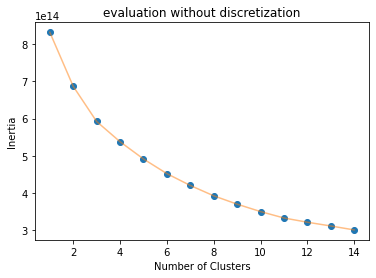

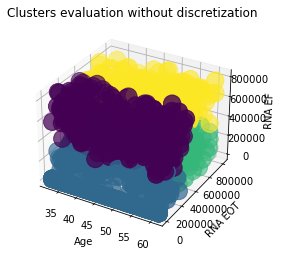

/home/filippocasari/.conda/envs/Sample1ProjectML/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:827: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.
  warnings.warn("algorithm='elkan' doesn't make sense for a single "


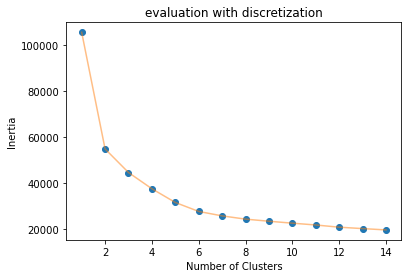

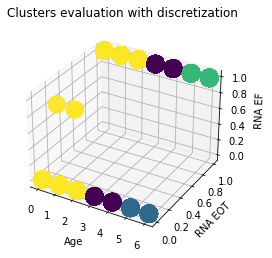

X:
      Age  Gender  BMI  Fever  Nausea or Vomiting  Headache   Diarrhea   \
0       5       0    4      2                   0          0          0   
1       3       0    2      1                   1          1          0   
2       5       0    3      2                   1          1          1   
3       4       1    3      1                   1          0          1   
4       6       0    3      1                   0          1          0   
...   ...     ...  ...    ...                 ...        ...        ...   
1380    3       0    2      1                   1          1          1   
1381    5       0    3      1                   1          1          0   
1382    2       0    2      2                   1          0          0   
1383    4       0    2      2                   0          0          1   
1384    5       1    2      1                   1          1          1   

      Fatigue & generalized bone ache   Jaundice   Epigastric pain   ...  \
0                   

/home/filippocasari/.conda/envs/Sample1ProjectML/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/filippocasari/.conda/envs/Sample1ProjectML/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/filippocasari/.conda/envs/Sample1ProjectML/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/filippocasari/.conda/envs/Sample1ProjectML/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [10]:
import os
import numpy as np
from mlxtend.plotting import plot_decision_regions
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel, SelectKBest, VarianceThreshold, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score, \
    precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier

import Cross_Valuation
import EDA
import Plotting
import Valuation
from Features_Selection import feature_selection_kbest
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, MinMaxScaler
from Logistic_Regression import Logistic_regression
from SVM_classifier import SVM_classifier

count_features = False
discretization_bool = True
problem_is_binarized = False
normalization = False
standardization = False
preproc = True


# used algorithms : Logistic Regression, DecisionTree, Clustering (K-means for evaluate number of classes)


def plot_metrics_for_each_features(X, name_png):
    figures = []
    names_cols = X.columns
    try:
        os.makedirs("./plots")
    except FileExistsError:
        # directory already exists
        pass
    fig, axes = plt.subplots(5, 6)
    index = 0
    j = 1
    for i in X.columns:
        '''
        figure = sns.displot(X, x=i)
        figures.append(figure)
        figure.savefig("./plots/" + str(i) + name_png)
        plt.close()  # plot close per chiudere la finestra di plot, onde evitare troppi  (>20)\
        # ed avere un errore a Runtime'''
        j += 1
        sns.catplot(data=X, x=i, kind="count")
        # axes[index].set_title(i)

    plt.show()


def splitting_train_test(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, random_state=0, train_size=0.8
    )
    return X_train, X_test, Y_train, Y_test


def select_best_features_with_kbest(X, Y, title, clf):
    X_train, X_test, Y_train, Y_test = splitting_train_test(X, Y)
    indexes = []
    accuracy_scores = []
    for i in range(3, 28):
        title = "Learning Curves with " + title
        selector = SelectKBest(chi2, k=i)
        selector.fit(X_train, Y_train)
        X_indices = np.arange(X.shape[-1])
        scores = selector.scores_
        scores /= scores.max()

        X_train_new = selector.transform(X_train)
        X_test_new = selector.transform(X_test)
        indexes.append(i)
        accuracy_scores.append(accuracy_score(Y_test, (clf.fit(X_train_new, Y_train)).predict(X_test_new)))
        print(str(accuracy_score(Y_test, (clf.fit(X_train_new, Y_train)).predict(X_test_new))) + " with " + str(
            i) + " features")
        # print(X_new.shape)
        print(" X with selection K BEST \n" + str(X.columns.values[selector.get_support()]))
        Plotting.plot_lc_curve(X_train_new, Y_train, title, i, clf)

    sns.barplot(x=indexes, y=accuracy_scores)
    plt.xlabel("K features")
    plt.ylim(0, 0.4)
    plt.ylabel("accuracy score")
    plt.show()

    # Plotting.plot_metrics_results(Y_test, y_pred, "Logistic Regression")


def feature_selection_varince(X_train, X_test):
    constant_filter = VarianceThreshold(threshold=0)
    constant_filter.fit(X_train)
    constant_columns = [column for column in X_train.columns
                        if column not in
                        X_train.columns[constant_filter.get_support()]]
    X_train = constant_filter.transform(X_train)
    X_test = constant_filter.transform(X_test)
    for column in constant_columns:
        print("Removed ", column)
    return X_train, X_test


def select_from_model(X, Y, clf, title):
    feature_names = X.columns
    X_train, X_test, Y_train, Y_test = splitting_train_test(X, Y)
    clf.fit(X_train, Y_train)
    model = SelectFromModel(clf, prefit=True)
    mask = model.get_support()  # list of booleans
    new_features = []  # The list of your K best features

    for bool, feature in zip(mask, feature_names):
        if bool:
            new_features.append(feature)
    X_new = pd.DataFrame(data=model.transform(X), columns=new_features)
    X_train, X_test, Y_train, Y_test = splitting_train_test(X_new, Y)
    print(" X with selection from model \n" + str(X_new))
    title = "Learning Curves with" + title + "with select from model)"
    Plotting.plot_lc_curve(X_train, Y_train, title)
    return X_new


def discretization_Age(i):
    if i in range(0, 33):
        i = 0
    elif i in range(33, 38):
        i = 1
    elif i in range(38, 43):
        i = 2
    elif i in range(43, 48):
        i = 3
    elif i in range(48, 53):
        i = 4
    elif i in range(53, 58):
        i = 5
    else:
        i = 6

    return i


def discretization_BMI(i):
    if i in range(0, 18):
        i = 0
    elif i in range(18, 25):
        i = 1
    elif i in range(25, 30):
        i = 2
    elif i in range(30, 35):
        i = 3
    elif i in range(35, 40):
        i = 4
    elif i in range(53, 58):
        i = 5

    return i


def discretization_WBC(i):
    if i in range(0, 4000):
        i = 0
    elif i in range(4000, 11000):
        i = 1
    elif i in range(11000, 12102):
        i = 2

    return i


def discretization_RBC(i):
    if 0 <= i < 3000000:
        i = 0
    elif 3000000 <= i < 5000000:
        i = 1
    elif 5018452 > i >= 5000000:
        i = 2

    return i


def discretization_Plat(i):
    if 93013 <= i < 100000:
        i = 0
    elif 100000 <= i < 225000:
        i = 1
    elif 225000 <= i < 226465:
        i = 2

    return i


def discretization_AST_ALT(i):
    if 0 <= i < 20:
        i = 0
    elif 20 <= i <= 40:
        i = 1
    elif 40 < i <= 128:
        i = 2

    return i


def discretization_HGB(df):
    print(df.loc[df.Gender == 1, 'HGB'])


def discretization_RNA(i):
    if 0 <= i <= 5:
        i = 0
    elif i > 5:
        i = 1

    return i


def discr_fun(X):
    X['Age'] = X['Age'].apply(discretization_Age)
    X['BMI'] = X['BMI'].apply(discretization_BMI)
    X['WBC'] = X['WBC'].apply(discretization_WBC)
    X['RBC'] = X['RBC'].apply(discretization_RBC)
    X['Plat'] = X['Plat'].apply(discretization_Plat)
    X['AST 1'] = X['AST 1'].apply(discretization_AST_ALT)
    X['ALT 1'] = X['ALT 1'].apply(discretization_AST_ALT)
    X['ALT 4'] = X['ALT 4'].apply(discretization_AST_ALT)
    X['ALT 12'] = X['ALT 12'].apply(discretization_AST_ALT)
    X['ALT 24'] = X['ALT 24'].apply(discretization_AST_ALT)
    X['ALT 36'] = X['ALT 36'].apply(discretization_AST_ALT)
    X['ALT 48'] = X['ALT 48'].apply(discretization_AST_ALT)
    X['RNA Base'] = X['RNA Base'].apply(discretization_RNA)
    X['RNA 4'] = X['RNA 4'].apply(discretization_RNA)
    X['RNA 12'] = X['RNA 12'].apply(discretization_RNA)
    X['RNA EOT'] = X['RNA EOT'].apply(discretization_RNA)
    X['RNA EF'] = X['RNA EF'].apply(discretization_RNA)

    return X


# TODO Target encoder sulle features
def converting_to_0_and_1(X):
    le = LabelEncoder()  # instanza che converte dal range [1,2,3,4] a [0,1,2,3]
    # i valori variano e possono essere 1 o 2. Li converto in 0 e 1 per maggior praticità
    X['Gender'] = le.fit_transform(X['Gender'])
    # print("Gender array: \n"+str(X['Gender']))
    X['Nausea or Vomiting'] = le.fit_transform(X['Nausea or Vomiting'])
    X['Headache '] = le.fit_transform(X['Headache '])
    X['Diarrhea '] = le.fit_transform(X['Diarrhea '])
    X['Fatigue & generalized bone ache '] = le.fit_transform(X['Fatigue & generalized bone ache '])
    X['Jaundice '] = le.fit_transform(X['Jaundice '])
    X['Epigastric pain '] = le.fit_transform(X['Epigastric pain '])

    return X


def counting_features(Y):
    if count_features:
        # inizio conteggio per ogni classe, per vedere se è bilanciato
        count_class_0 = 0
        count_class_1 = 0
        count_class_2 = 0
        count_class_3 = 0

        for i in Y:
            # print(i)
            if i == 0:
                count_class_0 += 1
            if i == 1:
                count_class_1 += 1
            if i == 2:
                count_class_2 += 1
            if i == 3:
                count_class_3 += 1
        print("samples of class 0: " + str(count_class_0))
        print("samples of class 1: " + str(count_class_1))
        print("samples of class 2: " + str(count_class_2))
        print("samples of class 3: " + str(count_class_3))


def normalization_and_standardization(X):
    scaler = StandardScaler()
    min_max_scaler = MinMaxScaler()
    names_cols = X.columns  # nomi delle colonne
    X_std = pd.DataFrame(scaler.fit_transform(X[names_cols]), columns=names_cols)
    X_scale = pd.DataFrame(min_max_scaler.fit_transform(X[names_cols]), columns=names_cols)
    return X_std, X_scale


def binarizing_problem(i):
    if i == 1 or i == 2:
        i = 0
    if i == 3 or i == 4:
        i = 1
    return i


def label_encoding(i_y):
    i_y = i_y - 1
    return i_y


if __name__ == '__main__':

    # Dati di input
    input_file = "./HCV-Egy-Data/HCV-Egy-Data.csv"
    df = pd.read_csv(input_file, header=0)
    print("Starting EDA...")
    # EDA.analysis_dataset(df.copy())

    print("EDA finished")
    # df describe, descrive il dataset, inizio EDA

    X = df.drop(columns='Baselinehistological staging')
    X_not_discret = X.copy()
    EDA.clustering(X_not_discret, "evaluation without discretization")
    if discretization_bool:
        X = discr_fun(X)
        EDA.clustering(X, "evaluation with discretization")

    Y = df['Baselinehistological staging']
    Y = Y.astype(int)  # converto in type int
    X = converting_to_0_and_1(X)

    X = X.drop(columns='HGB')
    df = pd.concat([X, Y], axis=1)
    # plot_metrics_for_each_features(df, "ciao")
    name_columns = X.columns
    print("X:\n" + str(X))
    # discretization_HGB(X) # TODO da rivedere

    # stesso preprocessing per l'array di output
    # Y = le.fit_transform(Y)

    print("DF after preprocessing: \n" + str(df))
    counting_features(Y)  # conto le features

    X_std, X_min_max = normalization_and_standardization(X)

    # TODO countplot, displot, pieplot, barplot, violin plot, pairplot
    # countplot ==> mette a confronto della classe target, feature più rilevante

    # print(names_cols + "\n" + str(len(names_cols)))
    # plot and save images, not preprocessing
    # plot_metrics_for_each_features(names_cols, X, "_not_preprocessing")

    # plot and save images, with standardizationount_class_0 = 0

    # plot_metrics_for_each_features(names_cols, X_std, "_standardized")

    # plot and save images, with min max scaler
    # plot_metrics_for_each_features(names_cols, X_scale, "min_max_scaler")

    if problem_is_binarized:
        Y = Y.apply(binarizing_problem)

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, random_state=0, train_size=0.70
    )

    # -----------------------Feature Selection---------------------------------

    clf_KNN_no_feat_sel = KNeighborsClassifier()
    # select_best_features_with_kbest(X, Y, "KNN", clf_KNN_no_feat_sel)
    X_train_new = pd.DataFrame(data=SelectKBest(k=3).fit_transform(X_train, Y_train),
                               columns=['Gender', 'BMI', 'ALT after 24 w'])
    X_test_new = pd.DataFrame(data=X_test, columns=X_train_new.columns)
    # --------------------------------END FEATURES SELECTION--------------------------------
    # --------------------------------------------------------------------------------------
    # --------------------------------CROSS VALIDATION----------------------------------
    # ---------------------------------------------------------------------------------------
    # Cross_Valuation.make_cross_evaluation(X_train_new, X_test_new, Y_train, Y_test)

    # X_train_new, X_test_new = feature_selection_varince(X_train, X_test)
    if problem_is_binarized:
        clf_DT = Pipeline(
            [('feature_selection', SelectFromModel(DecisionTreeClassifier(random_state=0))),
             ('classification', DecisionTreeClassifier(random_state=0))])
        clf_KNN = KNeighborsClassifier()


    else:

        clf_DT = Pipeline(
            [('feature_selection', SelectFromModel(DecisionTreeClassifier())),
             ('classification', DecisionTreeClassifier())])

        njobs = 4
        clf_KNN = Pipeline([('selector', SelectKBest(k=3)), ('classifier', KNeighborsClassifier())])

    if standardization:
        normalization = False
        X_train_std, X_test_std, Y_train, Y_test = train_test_split(
            X_std, Y, random_state=0, train_size=0.70
        )

        clf_DT.fit(X_train_std, Y_train)
        clf_KNN.fit(X_train_std, Y_train)
        y_pred_1 = clf_DT.predict(X_test_std)
        y_pred_2 = clf_KNN.predict(X_test_std)

    elif normalization:
        standardization = False

        X_train_minmax, X_test_minmax, Y_train, Y_test = train_test_split(
            X_min_max, Y, random_state=0, train_size=0.70
        )

        clf_DT.fit(X_train_minmax, Y_train)
        clf_KNN.fit(X_train_minmax, Y_train)
        y_pred_1 = clf_DT.predict(X_test_minmax)
        y_pred_2 = clf_KNN.predict(X_test_minmax)
    else:
        # analisi bontà del clustering
        clf_DT.fit(X_train, Y_train)
        clf_KNN.fit(X_train, Y_train)
        y_pred_1 = clf_DT.predict(X_test)
        y_pred_2 = clf_KNN.predict(X_test)

    X_train_new_2f = pd.DataFrame(data=X_train,
                                  columns=['RNA EF', 'RNA EOT'])
    X_test_new_2f = pd.DataFrame(data=X_test, columns=X_train_new.columns)
    # Cross_Valuation.make_cross_evaluation(X_train_new_2f, X_test_new_2f, Y_train, Y_test)
    y_KNN_without_preproc = clf_KNN_no_feat_sel.fit(X_train, Y_train).predict(X_test)

    # sns.displot(data=Y_test, x=Y_test.classes_)
    # plt.show()
    print("Preprocessing applied? " + str(preproc))
    print("Analysis with Discretization: " + str(discretization_bool))
    print("Problem is Binarized ?: " + str(problem_is_binarized))
    print("Standardization applied ? : " + str(standardization))
    print("Normalization applied? : " + str(normalization))

    print("accuracy score for KNeighbors: " + str(accuracy_score(Y_test, y_pred_2)))
    print("accuracy score for Decision tree: " + str(accuracy_score(Y_test, y_pred_1)))
    print("classification report for KNeighbors: \n" + str(classification_report(Y_test, y_pred_2)))
    print("classification report for Decision tree:\n " + str(classification_report(Y_test, y_pred_1)))
    y_predicted = []
    y_predicted.append(y_pred_2)
    y_predicted.append(y_pred_1)
    names_model = ['KNN', 'Decision Tree']
    # Valuation.valuating_models(names_model, Y_test, y_predicted)
    print("KNN without preprocessing:\n")
    print("accuracy score for KNeighbors: " + str(accuracy_score(Y_test, y_KNN_without_preproc)))

    print("classification report for KNeighbors: \n" + str(classification_report(Y_test, y_KNN_without_preproc)))
    parameters_dt = {'max_depth': list(range(1, 100, 2)), "criterion": ["gini", "entropy"],
                     "splitter": ["best", "random"]}
    parameters_knn = {'n_neighbors': list(range(1, 10, 2)), "weights": ["uniform", "distance"], "p": [1, 2]}

    knn_model = KNeighborsClassifier()
    decis_tree = DecisionTreeClassifier()
    '''
    Cross_Valuation.make_cross_evaluation(X_train_new, Y_train, knn_model, parameters_knn, "KNN with preprocessing")
    Cross_Valuation.make_cross_evaluation(X_train, Y_train, decis_tree, parameters_dt,
                                          "Decision Tree with preprocessing")
    Cross_Valuation.make_cross_evaluation(X_train, Y_train, knn_model, parameters_knn, "KNN without preprocessing")
    Cross_Valuation.make_cross_evaluation(X_train, Y_train, decis_tree, parameters_dt,
                                          "Decision Tree without preprocessing")
    '''

In [ ]:
    fig, ax = plt.subplots()
    X_std=StandardScaler().fit_transform(X[['RNA 12', 'RNA EOT']])
    decis_tree.fit(X_not_discret[['RNA 12', 'RNA EF']], Y)
    plot_decision_regions(X_not_discret[['RNA 12', 'RNA EF']].values, Y.values,decis_tree, ax=ax)
    ax.set_xlabel('RNA 12')
    ax.set_ylabel('RNA EF')
    fig.suptitle('DT plot')



    plt.show()